# Mini documentation sur l'utilisation de la librairie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tools import InterpolationType
from market_data.volatility_surface.svi_volatility import SVIVolatilitySurface
from market_data.rate_curve.rate_curve import RateCurve

## SVI volatility surface

Import des données

In [2]:
# Exemple pour APPL (données pas à jour)
spot = 225
option_data = pd.read_excel("data/option_data.xlsx")
option_data["Spot"] = spot
rate_data = pd.read_excel("data/yield_curves/RateCurve_temp.xlsx")

On instancie la courbe de taux et la surface de vol

In [3]:
curve = RateCurve(rate_data, InterpolationType.SVENSSON)
svi = SVIVolatilitySurface(option_data=option_data, rate_curve=curve)

c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\market_data\rate_curve\interpolators\svensson_interpolator.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term1 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\market_data\rate_curve\interpolators\svensson_interpolator.py:47: RuntimeWarning: invalid value encountered in scalar divide
  term2 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\market_data\rate_curve\interpolators\svensson_interpolator.py:48: RuntimeWarning: invalid value encountered in scalar divide
  term3 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))


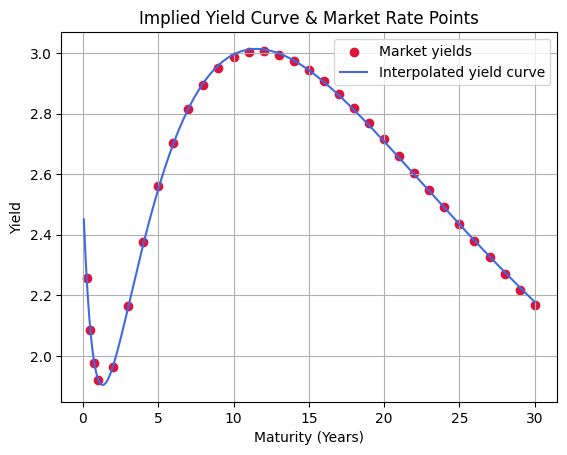

In [4]:
curve.display_curve()

On peut visualiser le fit du SVI :

In [5]:
svi.calibrate_surface()
print(svi.svi_params)

[-8.28020784e-01  4.45665340e+01 -5.88612814e-02  2.04871910e-02
  7.47417228e-02]


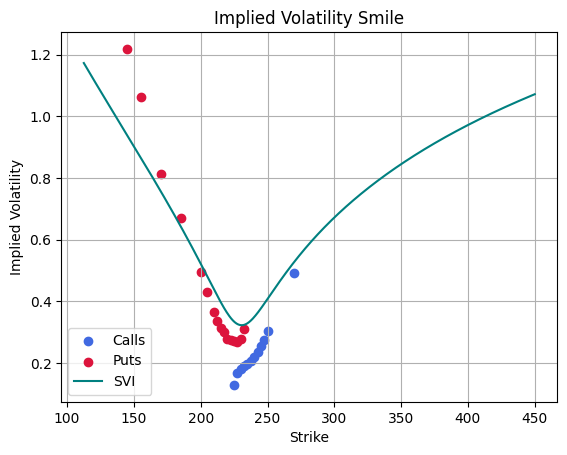

In [6]:
svi.display_smile(24)

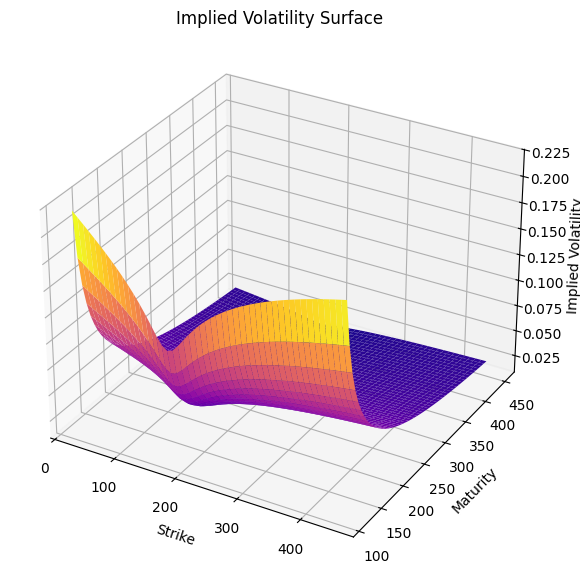

In [7]:
svi.display_surface()

Utilisation de la courbe de vol pour obtenir une vol pour un couple maturity/strike donné : 

In [8]:
print(svi.get_volatility(strike=200, maturity=100))

0.25572607274429704
